In [1]:
import torch        #kütüphaneler
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   #GPU varsa kullan
print(f"Kullanılan Cihaz: {device}")

torch.manual_seed(42)   #Rastgelelik için sabit tohum

Kullanılan Cihaz: cuda


In [2]:
import pandas as pd     #veri yükleme
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

train_csv_path = r'C:\Users\Efe\Desktop\archive\Training_Set\Training_Set\RFMiD_Training_Labels.csv'
val_csv_path   = r'C:\Users\Efe\Desktop\archive\Evaluation_Set\Evaluation_Set\RFMiD_Validation_Labels.csv'
test_csv_path  = r'C:\Users\Efe\Desktop\archive\Test_Set\Test_Set\RFMiD_Testing_Labels.csv'

train_img_dir = r'C:\Users\Efe\Desktop\archive\Training_Set\Training_Set\Training' 
val_img_dir   = r'C:\Users\Efe\Desktop\archive\Evaluation_Set\Evaluation_Set\Validation'   
test_img_dir  = r'C:\Users\Efe\Desktop\archive\Test_Set\Test_Set\Test'

class RFMiDDataset(Dataset):    #veri okuma
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_id = str(self.data_frame.iloc[idx, 0]) # İlk sütun ID

        img_name = f"{img_id}.png"
        img_path = os.path.join(self.root_dir, img_name)

        if not os.path.exists(img_path):
             img_name = f"{img_id}.jpg"
             img_path = os.path.join(self.root_dir, img_name)

        try:        # 2. Resmi Yükle
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, OSError):
            print(f"Uyarı: Resim bulunamadı -> {img_path}")
            image = Image.new('RGB', (256, 256), (0, 0, 0))

        label = int(self.data_frame.iloc[idx, 1]) 

        if self.transform:
            image = self.transform(image)

        return image, label

# Dönüşümler
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Veri Setlerini Oluştur
train_dataset = RFMiDDataset(csv_file=train_csv_path, root_dir=train_img_dir, transform=transform)
val_dataset   = RFMiDDataset(csv_file=val_csv_path,   root_dir=val_img_dir,   transform=transform)
test_dataset  = RFMiDDataset(csv_file=test_csv_path,  root_dir=test_img_dir,  transform=transform)

# DataLoader'ları Oluştur
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

print(f"Eğitim Verisi: {len(train_dataset)} adet")
print(f"Test Verisi:   {len(test_dataset)} adet")
print("Sınıflar: 0 (Sağlıklı), 1 (Hastalık Riski Var)")

Eğitim Verisi: 1920 adet
Test Verisi:   640 adet
Sınıflar: 0 (Sağlıklı), 1 (Hastalık Riski Var)


In [3]:
class BasicCNN(nn.Module):      #basic cnn modeli
    def __init__(self, num_classes=4):
        super(BasicCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 512), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_basic = BasicCNN(num_classes=2).to(device)
print("Basic CNN Modeli oluşturuldu.")

Basic CNN Modeli oluşturuldu.


In [4]:
import time     #eğitim fonksiyonu  

def train_model(model, criterion, optimizer, num_epochs=5):
    start_time = time.time()
    
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                dataloader = train_loader
            else:
                model.eval()   
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device) 
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.item())
                val_loss_history.append(epoch_loss)

    end_time = time.time() - start_time
    print(f'Eğitim tamamlandı. Toplam süre: {end_time // 60:.0f}dk {end_time % 60:.0f}sn')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer_basic = optim.Adam(model_basic.parameters(), lr=0.001)    # optimizasyon algoritması

print("Basic CNN Modeli Eğitiliyor... ")    #Eğitimi Başlat

num_epochs = 15 

b_train_acc, b_val_acc, b_train_loss, b_val_loss = train_model(
    model_basic, 
    criterion, 
    optimizer_basic, 
    num_epochs=num_epochs
)

print("Basic CNN eğitimi tamamlandı.")

Basic CNN Modeli Eğitiliyor... 
Epoch 1/15
----------
train Loss: 0.4788 Acc: 0.7875
val Loss: 0.4908 Acc: 0.7906
Epoch 2/15
----------
train Loss: 0.4541 Acc: 0.7917
val Loss: 0.4698 Acc: 0.8063
Epoch 3/15
----------
train Loss: 0.4351 Acc: 0.8167
val Loss: 0.4352 Acc: 0.8156
Epoch 4/15
----------
train Loss: 0.4219 Acc: 0.8219
val Loss: 0.4319 Acc: 0.8172
Epoch 5/15
----------
train Loss: 0.4172 Acc: 0.8229
val Loss: 0.4351 Acc: 0.8078
Epoch 6/15
----------
train Loss: 0.4159 Acc: 0.8224
val Loss: 0.4645 Acc: 0.8141
Epoch 7/15
----------
train Loss: 0.4080 Acc: 0.8260
val Loss: 0.4261 Acc: 0.8094
Epoch 8/15
----------
train Loss: 0.3834 Acc: 0.8349
val Loss: 0.4326 Acc: 0.8156
Epoch 9/15
----------
train Loss: 0.3737 Acc: 0.8333
val Loss: 0.4094 Acc: 0.8094
Epoch 10/15
----------
train Loss: 0.3509 Acc: 0.8495
val Loss: 0.4093 Acc: 0.8016
Epoch 11/15
----------
train Loss: 0.3398 Acc: 0.8573
val Loss: 0.4004 Acc: 0.8094
Epoch 12/15
----------
train Loss: 0.3375 Acc: 0.8521
val Loss: 

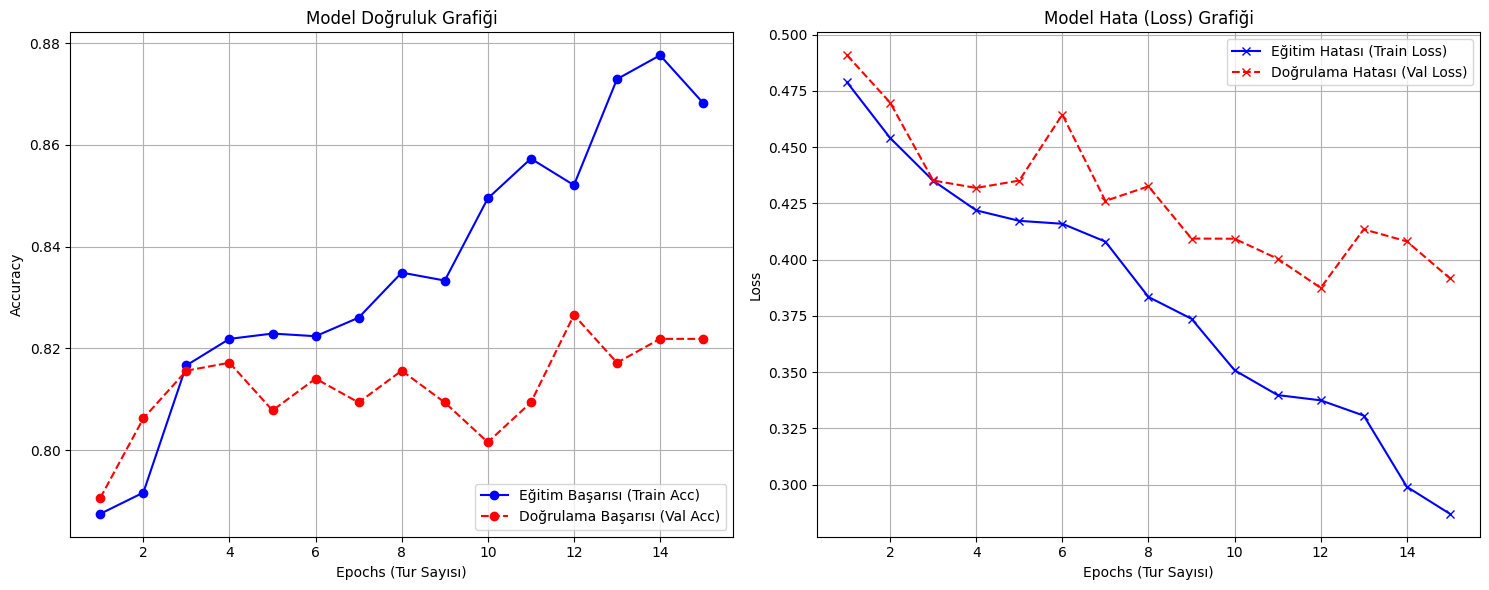

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(b_train_acc) + 1)

plt.figure(figsize=(15, 6))

#1. GRAFİK: DOĞRULUK (ACCURACY)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, b_train_acc, label='Eğitim Başarısı (Train Acc)', color='blue', marker='o')
plt.plot(epochs_range, b_val_acc, label='Doğrulama Başarısı (Val Acc)', color='red', marker='o', linestyle='--')

plt.title('Model Doğruluk Grafiği')
plt.xlabel('Epochs (Tur Sayısı)')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

#2. GRAFİK: KAYIP (LOSS)
plt.subplot(1, 2, 2)
plt.plot(epochs_range, b_train_loss, label='Eğitim Hatası (Train Loss)', color='blue', marker='x')
plt.plot(epochs_range, b_val_loss, label='Doğrulama Hatası (Val Loss)', color='red', marker='x', linestyle='--')

plt.title('Model Hata (Loss) Grafiği')
plt.xlabel('Epochs (Tur Sayısı)')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

class_names = ['Sağlıklı (Normal)', 'Hastalık Riski (Disease Risk)']

def evaluate_performance(model):
    model.eval() 
    all_preds = []
    all_labels = []
    all_probs = []
    
    print("Test Seti üzerinde performans ölçülüyor...")
    
    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1) 
            _, preds = torch.max(outputs, 1)  
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Numpy array'e çevir
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    acc = accuracy_score(all_labels, all_preds)
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    try:
        auc = roc_auc_score(all_labels, all_probs[:, 1])
    except:
        auc = 0.0 # Hesap hatası olursa

    print(f"\n=== BASIC CNN PERFORMANS RAPORU ===")
    print(f"Accuracy (Doğruluk):  %{acc*100:.2f}")
    print(f"F1-Score (Denge):     {f1:.4f}")
    print(f"ROC AUC (Ayırt Gücü): {auc:.4f}")
    print("="*35)

evaluate_performance(model_basic)   # Performansı ölç

Test Seti üzerinde performans ölçülüyor...

=== BASIC CNN PERFORMANS RAPORU ===
Accuracy (Doğruluk):  %85.94
F1-Score (Denge):     0.8578
ROC AUC (Ayırt Gücü): 0.8825
